# Assignment 5
#### Filip Sjövall -  19950308-5699

In [5]:
import numpy
import scipy
from numpy import linalg
from scipy import linalg
from scipy import optimize
import matplotlib.pyplot as plt
import math 
import sys, getopt, os, string

## Task 1.
- Dependency on p: It seems that for increasing values of p the Gerschgorin discs become bigger, which is in accordance with his theorem $|\lambda - A_{ii}| = \sum^n_{j=1, j\neq i} | A_{ij} |$ which relates the difference between the diagonal entries of a matrix A to it's eigenvalues by the sum of it's off-diagonal components, increasing the off-diagonal elements should then increase the "radius" in which lambda could be then. It can also be noticed that for varying values of p the eigenvalues of A (red dots) move.

[5.000 0.000 -2.000 -3.000]
[5.002 -0.002 -1.961 -3.040]
[5.007 -0.004 -1.864 -3.139]
[5.016 -0.002 -1.744 -3.269]
[5.029 0.007 -1.623 -3.414]
[5.047 0.031 -1.515 -3.563]
[5.070 0.075 -1.432 -3.713]
[5.099 -3.862 -1.381 0.144]
[5.133 -4.007 -1.364 0.238]
[5.173 -4.148 -1.380 0.355]


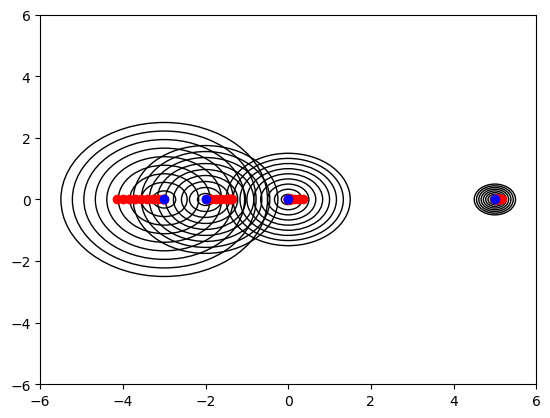

In [6]:
A = [ [ 5,  0,   0, -1],
      [ 1,   0, -1,  1],
      [-1.5, 1, -2,  1],
      [-1,   1,  3, -3]]

def scaleP(A,p):
    m,n = np.shape(A)
    for i in range (0,m):
        for j in range(0,n):
            if i!=j:
              A[i][j] = A[i][j]*p  
    return A

p = np.linspace(0.0,1,10)


fig, ax = plt.subplots()

for s in p:
    A2  = scaleP(np.copy(A),s)
    u,v = np.linalg.eig(A2)

    x = np.real(u)
    y = np.imag(u)
    
    print(u)
    for i in range(0,4):
        d = 0.0
        for j in range(0,4):
            if j!=i:
                d+=np.abs(A2[i][j])
        c = plt.Circle( (A2[i][i],0), d/2, fill=False)
        ax.add_artist( c )
    plt.plot(x,y,'ro')
plt.plot(np.diag(A),np.zeros(4),'bo')    
plt.xlim(-6, 6)
plt.ylim(-6, 6)
plt.show()

## Task 2
QR with Rayleigh shifts and deflations. The previously implemented QR-factorization can be utilized to find the eigenvalues of a matrix A. The idea is for a sequence apply $A_{k+1}=R_k Q_k$ to obtain an upper triangular matrix (this is only true if some conditions are met) for which the eigenvalues will be on the diagonal. This is similar to QR-factorization in the sense that $R_kQ_k = Q_k^{-1}Q_kR_kQ_k = Q_k^T A_k Q_k$ i.e. we apply a series of orthogonal matrices $Q_k$ to until a desired format is achieved.

Rayleigh shift we subtract a number $\mu$ from the diagonal from A. The idea is to shift the eigenvalues such that max of the quotient between the absolute value of two subsequent values is larger $|\lambda_{j+1}|/|\lambda_{j}|$, which for the QR-algorithm yields faster convergence. If we use the Rayleigh quotient as the shift we get
\begin{equation}
     \mu_m^{(k)} = \frac{ (q_m^{(k)})^T A q_m^{(k)} }{(q_m^{(k)})^T q_m^{(k)}  }  = (q_m^{(k)})^T A q_m^{(k)} = 
     (e_mQ_m^{(k)})^T A e_mQ_m^{(k)} = (e_m)^T A^{(k)} e_m = A^{(k)}_{mm}
\end{equation}
which is convenient because we have $\mu^k$ on the diagonal of $A^k$

Deflations means we split A when we find zeros on the subdiagonal and use QR on the resulting submatrices.

My algorithm was quite slow so it was only ran up to rather small matrices and averaged the number of iterations (counting iterations inside the deflations too) for 10 different random matrices. The plot below shows the number of iterations versus the number of rows/columns of A, which is rather jagged, possibly due to the random function or implementation errors. Disregarding spikes in the graph the iterations used seems to have a linear dependence on matrix size seems to.

In [7]:
def practical_qr(A):
    A0  = A
    m,n = np.shape(A)
    if m==0 & n==0:
        return A,0
    Q   = np.zeros((n,n))
    R   = np.zeros((n,n))
    my  = 0.0
    for i in range(0,100000):   
        my = A[-1,-1]
        Q,R = np.linalg.qr( (  A - my*np.eye(n) ) )
        A   = R@Q + my*np.eye(n)
        for k in range(1,n-1):
            if (np.abs(A[k,k+1]) < 1e-8)  : # & ( np.abs(A[k+1,k]) < 1e-8) ??
                A[k,k+1] = 0.0
                A[k+1,k] = 0.0
                A[:k,:k],i1         = practical_qr(np.copy(A[:k,:k]))
                A[k+1:,k+1:],i2   = practical_qr(np.copy(A[k+1:,k+1:]))
                i+=i1
                i+=i2
                #if i1 < i2:
                #    i+=i2
                #else:
                    #i+=i1
                break
        u,v = np.linalg.eig(A)
        if np.linalg.norm( np.sort(u) - np.sort(np.diag(A)),2) < 1e-8:    
            break
    return A,i

0 0 0.0
1 1 0.0
2 2 24.0
3 3 81.0
4 4 164.0
5 5 143.0
6 6 230.0
7 7 326.0
8 8 1055.0
9 9 294.0
10 10 3141.0
11 11 336.0
12 12 240.0
13 13 242.0
14 14 218.0
15 15 230.0
16 16 168.0
17 17 780.0
18 18 458.0
19 19 315.0


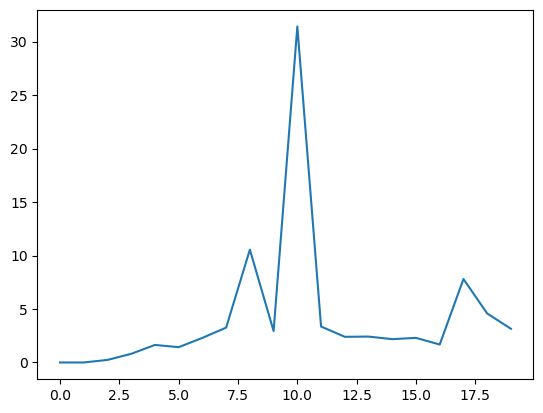

In [13]:
# Reduce number of decimals to make matrices easier to read
np.set_printoptions(formatter={'float': lambda x: "{0:0.3f}".format(x) })
m    = 20
step = 1
iter = np.zeros(int(np.floor(m/step))) 
res  = iter
count= -1
for n in range(0,m,step):
    isum = 0.0
    count +=1
    for j in range(0,10):
        A = np.random.rand(n,n)
        A = 0.5 * (A + A.T)
        #A = scipy.linalg.hessenberg(np.copy(A))
        A0,i = practical_qr(np.copy(A))
        u,v = np.linalg.eig(A)
        res[count]+=np.linalg.norm( np.sort(u) - np.sort(np.diag(A0)),2)
        isum      +=i
    iter[count]=isum/10
    res[count] = res[count]/10
    
plt.plot(iter)
plt.show()

8


1.0

## Task 3
- a)
The submatrix of $A-\lambda I$ if we don't consider the first row and last column will be upper triangular and non-singular (since it has nonzero values on the diagonal). Furthermore the eigenvalues will be the diagonal entries and it will be invertible (since the determinant will be nonzero) so the rank of the submatrix will be $m-1$, therefore the rank of A is $\geq m-1$. Thus the rank of the nullspace of A i.e. the geometric multiplicity of A is 1. The geometric multiplicity never can exceed  the algebraic multiplicity (number times $\lambda$ is a root of A) that too is 1. This means that A should have distinct eigenvalues.

- b) A Hessenberg matrix is a matrix with zeros below its first subdiagonal. An example would be 
\begin{equation}
A = 
\begin{bmatrix}
0 & 0 & 0 & 0 \\
1 & 0 & 0 & 0 \\
0 & 1 & 0 & 0 \\
0 & 0 & 1 & 0
\end{bmatrix},
\end{equation}
which does not have distinct eigenvalues.

## Task 4
### The bisection algorithm.
I did not finish this task, but from my understanding the idea is to utilize the bisection linesearch method to find roots of the characteristic polynomial $p(x)$ but instead of using function values to determine in which interval to search we check the number of sign changes in the sequence of characteristic polynomial of the upper left submatrices of $A$ namely $p_1,p_2(x),...,p_k(x)$ $A_k$, which should be less prone to ill-conditioning issues than a regular root-finding algorithm. For a tridiagonal matrix we know that the eigenvalues are interlaced and that the number of sign switches in $p_k(x)$ tells us how many eigenvalues are in $[-\infty,x)$. Thus when we half our intervall in the bisection method we have a way of telling how many eigenvalues lie in each half, which is utilized to locate the eigenvalues.

In [248]:
def pol(x,A,k):
    a_k = numpy.float64(A[k,k])
    b_k = numpy.float64(A[k-1,k])
    x   = numpy.float64(x)
    if k == -1:
        p = 0
    elif k==0:
        p = 1
    elif k==1:
        p   =  (a_k - x) 
    else:
        p   =  (a_k - x) * pol(x,A,k-1) - b_k**2 * pol(x,A,k-2)
    return p

def sequence(A,k):
    list = np.zeros(k+1)
    list[0] = 1
    count   = 0
    for i in range(0,k):
        if i==0:
            list[i+1] = A[i,i]
        else:
            list[i+1] = np.linalg.det(A[0:i+1,0:i+1])
        if np.sign(list[i+1])!=np.sign(list[i]):
            count +=1
    return list,count


[[0.310 -1.144 0.000 0.000 0.000]
 [-1.144 1.944 0.619 0.000 0.000]
 [0.000 0.619 0.570 -0.150 0.000]
 [0.000 0.000 -0.150 0.085 -0.091]
 [0.000 0.000 0.000 -0.091 0.043]]
1.944200288001241
eig  [2.679 0.561 -0.379 0.133 -0.041]
